# Task
The goal of this project was to build a face detection model using only scikit-learn and no neural networks.

I followed the approach of early face detection methods, based on the paper: Face Detection: Histogram of Oriented Gradients and Bag of Feature Method, whose link I attach below, as my cues:
https://www.researchgate.net/publication/342886529_Face_Detection_Histogram_of_Oriented_Gradients_and_Bag_of_Feature_Method


I prepared two datasets:
- Positive patches: images of faces with feature value = 1
- Negative patches: random images of non-faces with feature value = 0
I computed the HOG (Histogram of Oriented Gradients) features for each patch and trained an SVM (Support Vector Machine) classifier.
I applied the model to images with multiple objects, using the sliding window and image pyramid techniques to extract patches of different sizes and locations. I used the NMS (Non-Maximum Suppression) algorithm to eliminate overlapping and redundant detections and keep only the best ones.

The main sources that I used for this project are:
- HOG: https://towardsdatascience.com/hog-histogram-of-oriented-gradients-67ecd887675f
- Sliding Windows for Object Detection: https://pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/
https://pyimagesearch.com/2015/03/16/image-pyramids-with-python-and-opencv/
- Non-Max Suppression (NMS) IOU (Intersection over Union): https://medium.com/analytics-vidhya/non-max-suppression-nms-6623e6572536
https://medium.com/analytics-vidhya/iou-intersection-over-union-705a39e7acef

# Functions


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from itertools import chain
import random
import joblib


# Libraries to train model
from sklearn.decomposition import PCA
from skimage.feature import hog
from skimage import exposure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


# I create a snippet to print more than one data for line of code
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#I save username and api key to import various datasets from kaggle
os.environ['KAGGLE_USERNAME'] = 'nicoferr98'
os.environ['KAGGLE_KEY'] = '722ddc54852f973bfc164b3119871c98'

# and I create a random seed
RANDOM_SEED = 0

In [ ]:
#Fuction to show the first 25 picture in my datasets
def plot_images(img, n_row=5, n_images=5, title=True):
  """
  Displays a grid of images in grayscale.

  Args:
    img : A list of images to display. Each image must be a two-dimensional array of intensity values.
    n_row : The number of rows of the grid. The default is 5.
    n_images : The number of images per row. The default is 5.
    title : If True, displays the title of each image with its index. The default is True.

  Return:
    A pyplot object that contains the figure and the axes.

  """
  fig, axes = plt.subplots(n_row, n_images, figsize=(10, 10))
  axes = axes.flatten()
  for i, image in enumerate(img[:(n_row*n_images)]):
      axes[i].imshow(image, cmap='gray')
      axes[i].axis('off')
      if title:
        axes[i].set_title(f'Image {i+1}')

  return plt.show





# Function to extract HOG features
def extract_hog_features(patches, orient=9, pixels_per_cell=(8,8), cells_per_block= (3,3)):
  """
  Computes HOG from a dataset of images.

  Args:
    patches: The input dataset. It must be a two-dimensional array of intensity values.
    orient : The number of orientation bins for the HOG. The default is 9.
    pixels_per_cell : The size of a cell in pixels. It must be a tuple of two positive integers. The default is (8,8).
    cells_per_block : The number of cells in each block. It must be a tuple of two positive integers. The default is (3,3).

  Return:
    features_list: list of np.array of HOG extracted
    visualizer_list: list of np.array for visualize it

  """
  features_list = []
  visualizer_list = []
  for p in patches:
    f, viz = hog(p, orientations=orient, pixels_per_cell=pixels_per_cell,
                               cells_per_block=cells_per_block, visualize=True)
    f = exposure.equalize_hist(f)
    features_list.append(f)
    visualizer_list.append(viz)
  return(features_list,visualizer_list)




# Function to extract HOG features from the test images
def hog_test(img, orient=9, pixels_per_cell=(8,8), cells_per_block= (3,3)):
  """
  Computes HOG for an image.

  Args:
    img :  The input image. It must be a two-dimensional array of intensity values.
    orient : The number of orientation bins for the HOG. The default is 9.
    pixels_per_cell : The size of a cell in pixels. It must be a tuple of two positive integers. The default is (8,8).
    cells_per_block : The number of cells in each block. It must be a tuple of two positive integers. The default is (3,3).

  Return:
    A one-dimensional array of HOG values. The length of the array depends on the size of the image and the parameters.
  """
  f = hog(img, orientations=orient, pixels_per_cell=pixels_per_cell,
                               cells_per_block=cells_per_block)
  f = exposure.equalize_hist(f)
  return(f)





# Function to show the real image near the HOG image
def show_hog_plot(normal_image, hog_image):
  """
  Displays a random pair of input image and its HOG representation.

  Args:
    normal_image : A list of input images. Each image must be a two-dimensional array of intensity values.
    hog_image : A list of HOG images. Each image must be a two-dimensional array of HOG values.

  Return:
    A pyplot object that contains the figure and the axes.
  """
  fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(8, 8))

  i = random.randrange(len(normal_image))

  ax1.imshow(normal_image[i], cmap='gray')
  ax1.set_title(f'Input image n.{i}')
  ax2.imshow(hog_image[i], cmap='gray')
  ax2.set_title(f'Histogram of Oriented Gradients (HOG) of image n.{i}')

  return plt.show


def IOU(box1, box2):
  """
  Computes the intersection over union (IOU) between two bounding boxes.

  Args:
  box1 : The first bounding box. It must be a list of four values: [x1, y1, x2, y2], where (x1, y1) and (x2, y2) are the coordinates of the top-left and bottom-right corners.
  box2 : The second bounding box. It must be a list of four values: [x3, y3, x4, y4], where (x3, y3) and (x4, y4) are the coordinates of the top-left and bottom-right corners.

  Return:
    The IOU value between the two boxes. It is a number between 0 and 1, where 0 means no overlap and 1 means complete overlap.
  """
  x1,y1,x2,y2 = box1
  x3,y3,x4,y4 = box2
  x_inter1 = max(x1, x3)
  y_inter1 = max(y1, y3)
  x_inter2 = min(x2, x4)
  y_inter2 = min(y2, y2)

  width_inter = abs(x_inter2 - x_inter1)
  height_inter = abs(y_inter2 - y_inter1)

  area_inter = width_inter*height_inter

  area_box1 = abs(x2 - x1) * abs(y2 - y1)
  area_box2 = abs(x4 - x3) * abs(y4 - y3)
  area_union = area_box1 + area_box2 - area_inter

  if area_union == 0:
    iou = 0
  else:
    iou = area_inter / area_union

  return iou



def nms(boxes, conf_treshold, iou_treshold):
  """
  Performs non-maximum suppression (NMS) on a list of bounding boxes.

  Args:
    boxes : A list of bounding boxes. Each box must be a list of five values: [x1, y1, x2, y2, confidence],
    where (x1, y1) and (x2, y2) are the coordinates of the top-left and bottom-right corners and confidence is the detection score.
    conf_treshold : The minimum confidence score to keep a box. It must be between 0 and 1.
    iou_treshold : The maximum intersection over union (IOU) to keep two boxes of the same class. It must be between 0 and 1.

  Return:
    A list of bounding boxes after NMS. The boxes are sorted by confidence in descending order.
  """
  bbox_list_tresholded = []
  bbox_list_new = []

  #Stage 1: sort boxes, and filter out boxes with low confidence
  boxes_sorted = sorted(boxes, reverse = True, key = lambda x : x[4])
  for box in boxes_sorted:
    if box[4] > conf_treshold:
      bbox_list_tresholded.append(box)
    else:
        pass
  #Stage 2: loop over all boxes and remove boxes with high IOU
  while len(bbox_list_tresholded) > 0:
    current_box = bbox_list_tresholded.pop(0)
    bbox_list_new.append(current_box)
    for box in bbox_list_tresholded:
        iou = IOU(current_box[:4], box[:4])
        if iou > iou_treshold:
          bbox_list_tresholded.remove(box)

  return bbox_list_new




import imutils
from skimage import transform
def pyramid(image, scale=1.2, minSize=(64, 64)):
  yield image
  """
  Generates a pyramid of resized images from an original image.

    Args:
    image : The original image. It must be a two-dimensional or three-dimensional array of intensity or color values.
    scale : The reduction factor of the image. It must be a real number greater than 1. The default is 1.5.
    minSize : The minimum size of the image. It must be a tuple of two positive integers. The default is (30, 30).

    Return:
        A generator object that yields the resized images. The first image is the original image, and the subsequent images are smaller by a factor of scale. The generator stops when the image size is smaller than minSize.
  """
  while True:
    w = int(image.shape[1] / scale)
    image = imutils.resize(image, width=w)
    if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
      break


      yield image

def sliding_window(image, stepSize, windowSize):
  """
  Generates a sliding window of a fixed size over an image.

    Args:
    image : The input image. It must be a two-dimensional or three-dimensional array of intensity or color values.
    stepSize : The step size of the sliding window. It must be a positive integer.
    windowSize : The size of the sliding window. It must be a tuple of two positive integers.

    Return:
      A generator object that yields the coordinates and the cropped image of each window.
      The coordinates are a tuple of (x, y), where x and y are the top-left corner of the window.
      The cropped image is a subarray of the input image with the same shape as windowSize.
  """
  for y in range(0, image.shape[0], stepSize):
    for x in range(0, image.shape[1], stepSize):
      yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])







# small fuction to the test the accuracy of model on images of faces
def predict_test_image(file_path, size, model):
  """
  Loads an image from a file path, resizes it, extracts HOG features, and predicts its class using a model.

  Args:

  file_path : The path of the image file. It must be a valid path to a grayscale image.
  size : The size of the resized image. It must be a positive integer.
  model : The model to use for prediction. It must have a predict method that takes a HOG feature vector as input and returns a class label as output.

  Return:
    A tuple of two elements: the predicted class label and the resized image
    """
  load_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
  resized_img = cv2.resize(load_image, (size))
  scaled_img = resized_img/255
  hog_img = hog_test(scaled_img)
  hog_img = np.reshape(hog_img,(1,-1))
  prediction = model.predict(hog_img)

  return prediction,resized_img






def draw_bounding_boxes(image, bbox_list):
  """
    Draws bounding boxes on an image and displays it.

    Args:
    image : The input image. It must be a two-dimensional or three-dimensional array of intensity or color values.
    bbox_list : A list of bounding boxes.
    Each box must be a list of five values: [x1, y1, x2, y2, class],
    where (x1, y1) and (x2, y2) are the coordinates of the top-left and bottom-right corners,
    and class is the object category.
    """
  image_with_bboxes = image.copy()

  for bbox in bbox_list:
    x1, y1, x2, y2, _ = bbox
    cv2.rectangle(image_with_bboxes, (x1, y1), (x2, y2), (0, 255, 0), 2)

  plt.imshow(image_with_bboxes, cmap='gray')
  cv2.waitKey(0)
  cv2.destroyAllWindows()


## Data Augmentation

In [ ]:
#original script found on https://imgaug.readthedocs.io/
import imgaug as ia
import imgaug.augmenters as iaa

def img_augmentation(img_set,k=1):
    """
    img_set - np.array with shape (n,w,h), where n is the number of images and w,h are width and height
    augment_function  - Fliplr (horiziontal flip)
                      - Flipud (vertical flip)
                      - Contrast (contrast augmentation)
    k - constant, precentage of images randomly chosen from the original set of images
    """

    n_images=np.array(img_set).shape[0]
    aug_set=[]
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    for i in range(1,int(k*n_images)):
        r=np.random.choice(n_images,1)[0]

        hflip= iaa.Fliplr(p=0.5)
        aug_hor_image= hflip.augment_image(img_set[r])
        aug_set.append(aug_hor_image)

        vflip= iaa.Flipud(p=0.5)
        aug_ver_image= vflip.augment_image(img_set[r])
        aug_set.append(aug_ver_image)

        contrast = iaa.LinearContrast((0.75, 1.5))
        aug_contrast_image = contrast.augment_image(img_set[r])
        aug_set.append(aug_contrast_image)

    return np.array(aug_set)

# Dataset

In [ ]:
#I import "lfw dataset" and I save it as positive patch dataset for the face detection task
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
lfw_positive_patches = faces.images
lfw_positive_patches = [cv2.resize(lfw, (64,64)) for lfw in lfw_positive_patches ]
lfw__patches = np.array(lfw_positive_patches)
lfw__patches.shape

(13233, 64, 64)

In [ ]:
#I import "olivetti faces dataset" and I save it as positive patch dataset for the face detection task
from sklearn.datasets import fetch_olivetti_faces
olivetti = fetch_olivetti_faces()

olivetti_patches = olivetti.images
olivetti_patches.shape

(400, 64, 64)

In [ ]:
#I download from kaggle the home-office-dataset as negative patch for my face detection task
!kaggle datasets download -d karntiwari/home-office-dataset
!unzip home-office-dataset.zip

# import negative object patches
FOLDER = '/content/OfficeHomeDataset_10072016/Real World'
neg_patches=[]
for p in os.listdir(FOLDER):
  path = FOLDER +'/'+ p
  for f in os.listdir(path):
    image = cv2.imread(path+'/'+ f, cv2.IMREAD_GRAYSCALE)
    img_resize = cv2.resize(image,(128,128))
    neg_patches.append(img_resize)

neg_patches= np.array(neg_patches)

In [ ]:
# fuction to extract random patches for the negative patches
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size= olivetti_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=RANDOM_SEED)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 2, scale)
                              for im in neg_patches for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(21785, 64, 64)

# Pre-training

Olivetti Faces dataframe dimensions: (400, 64, 64) 
Max value of pixels: 1.0 
Min value of pixels: 0.0


<function matplotlib.pyplot.show(close=None, block=None)>

LFW Faces dataframe dimensions: (13233, 64, 64) 
Max value of pixels: 1.0 
Min value of pixels: 0.0


<function matplotlib.pyplot.show(close=None, block=None)>

Object dataframe dimensions: (21785, 64, 64) 
Max value of pixels: 255.0 
Min value of pixels: 0.0


<function matplotlib.pyplot.show(close=None, block=None)>

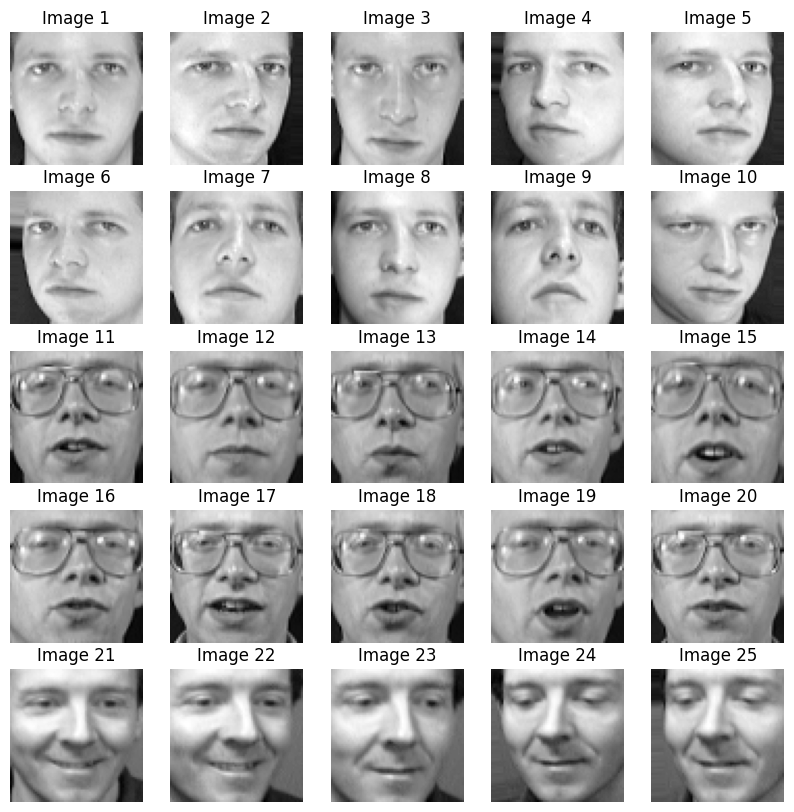

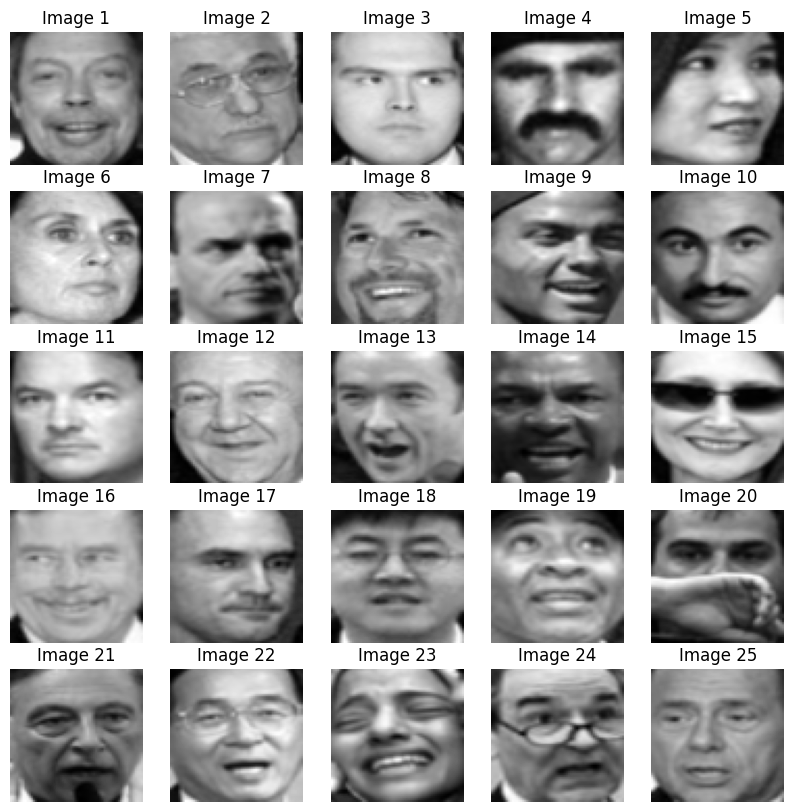

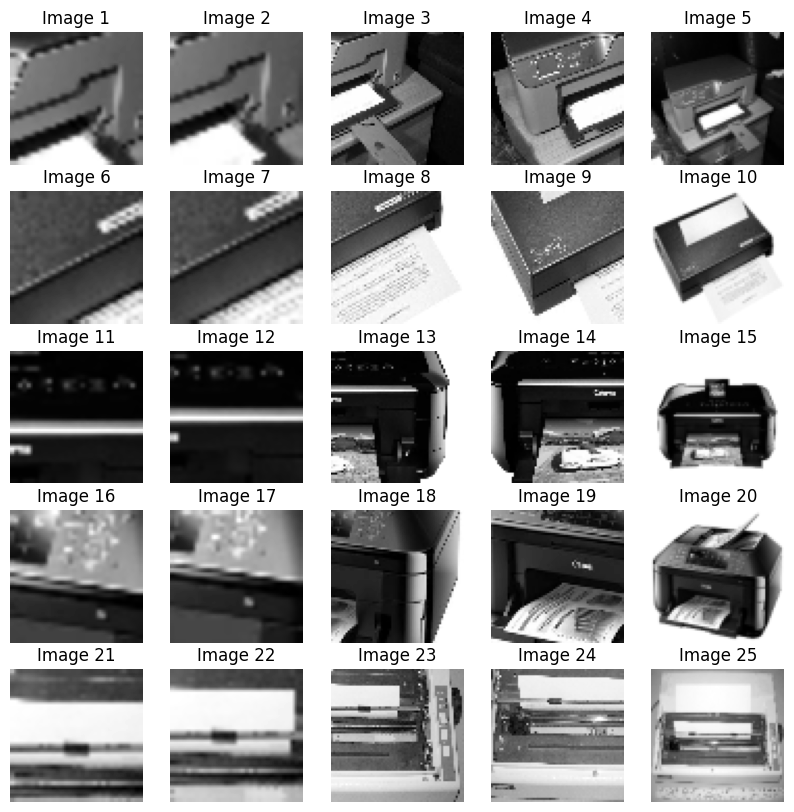

In [ ]:
#I print some infoes on dataset
print(f'Olivetti Faces dataframe dimensions: {olivetti_patches.shape}',
      '\n' f'Max value of pixels: {np.max(olivetti_patches)}',
      '\n' f'Min value of pixels: {np.min(olivetti_patches)}')
plot_images(olivetti_patches, title=True)

print(f'LFW Faces dataframe dimensions: {lfw__patches.shape}',
      '\n' f'Max value of pixels: {np.max(lfw__patches)}',
      '\n' f'Min value of pixels: {np.min(lfw__patches)}')
plot_images(lfw__patches, title=True)

print(f'Object dataframe dimensions: {negative_patches.shape}',
      '\n' f'Max value of pixels: {np.max(negative_patches)}',
      '\n' f'Min value of pixels: {np.min(negative_patches)}')
plot_images(negative_patches, title=True)

Number of positive patches: 13633
New number of negative patches: 21785


<function matplotlib.pyplot.show(close=None, block=None)>

<function matplotlib.pyplot.show(close=None, block=None)>

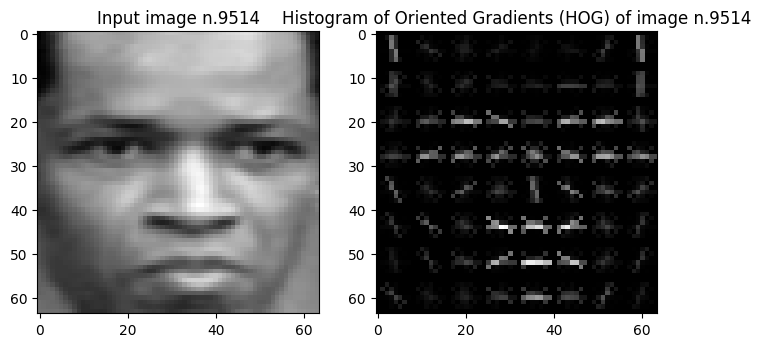

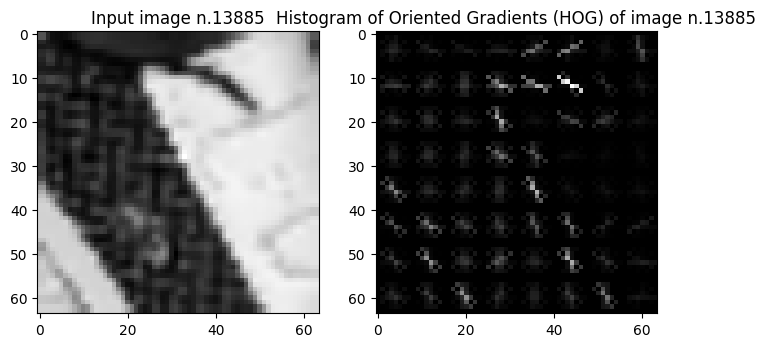

In [ ]:
# concate two positive datasets
pos_patches = np.concatenate((olivetti_patches, lfw__patches),axis=0)
# scale negative dataset
neg_patches = negative_patches/255
print(f'Number of positive patches: {pos_patches.shape[0]}\nNew number of negative patches: {neg_patches.shape[0]}')


# I extract HOG features
pos_hog, pos_hog_visualizer = extract_hog_features(pos_patches)
neg_hog, neg_hog_visualizer = extract_hog_features(neg_patches)

# and I show some exaple of HOG extractions
show_hog_plot(pos_patches, pos_hog_visualizer)
show_hog_plot(neg_patches, neg_hog_visualizer)

# Training

In [ ]:
x = np.concatenate((pos_hog, neg_hog),axis=0)
print(x.shape)
y = np.zeros(x.shape[0])
y[:len(pos_patches)]=1
labels, counts = np.unique(y, return_counts=True)
print(f'X shape: {x.shape} and label dimension: Label 1 = {counts[-1]}, Label 0 = {counts[0]}')


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)
print(X_train.shape, y_train.shape)

(35418, 2916)
X shape: (35418, 2916) and label dimension: Label 1 = 13633, Label 0 = 21785
(24792, 2916) (24792,)


In [ ]:
from sklearn.pipeline import Pipeline
param_grid = {
    'svm__C': [1,10,100],
    'svm__kernel': ['linear', 'rbf']
}
face_detection_pipe = Pipeline([
                      ('svm',SVC(probability=True,gamma='auto'))
                      ])
grid_pipeline = GridSearchCV(face_detection_pipe, param_grid,cv=3, verbose=3)
grid_pipeline.fit(X_train, y_train)


svc = grid_pipeline.best_estimator_
svc.fit(X_train, y_train)

print(classification_report(y_test, svc.predict(X_test)))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ......svm__C=1, svm__kernel=linear;, score=0.990 total time= 1.7min
[CV 2/3] END ......svm__C=1, svm__kernel=linear;, score=0.990 total time= 1.8min
[CV 3/3] END ......svm__C=1, svm__kernel=linear;, score=0.989 total time= 1.8min
[CV 1/3] END .........svm__C=1, svm__kernel=rbf;, score=0.992 total time= 5.3min
[CV 2/3] END .........svm__C=1, svm__kernel=rbf;, score=0.992 total time= 5.3min
[CV 3/3] END .........svm__C=1, svm__kernel=rbf;, score=0.993 total time= 5.3min
[CV 1/3] END .....svm__C=10, svm__kernel=linear;, score=0.990 total time= 1.7min
[CV 2/3] END .....svm__C=10, svm__kernel=linear;, score=0.990 total time= 1.8min
[CV 3/3] END .....svm__C=10, svm__kernel=linear;, score=0.989 total time= 1.7min
[CV 1/3] END ........svm__C=10, svm__kernel=rbf;, score=0.993 total time= 2.7min
[CV 2/3] END ........svm__C=10, svm__kernel=rbf;, score=0.994 total time= 2.6min
[CV 3/3] END ........svm__C=10, svm__kernel=rbf;,

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('svm',
                                        SVC(gamma='auto', probability=True))]),
             param_grid={'svm__C': [1, 10, 100],
                         'svm__kernel': ['linear', 'rbf']},
             verbose=3)

Pipeline(steps=[('svm', SVC(C=10, gamma='auto', probability=True))])

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      6536
         1.0       1.00      0.99      0.99      4090

    accuracy                           1.00     10626
   macro avg       1.00      0.99      1.00     10626
weighted avg       1.00      1.00      1.00     10626



In [ ]:
grid_pipeline.best_params_

{'svm__C': 10, 'svm__kernel': 'rbf'}

In [ ]:
# save the model with joblib
import joblib
file_name = 'face_detection_grid_model.sav'
joblib.dump(svc,file_name)

['face_detection_grid_model.sav']

# Test

In [ ]:
#snippet of code to import variuous file
from google.colab import files
file = files.upload()

Saving face test.png to face test.png


In [ ]:
pred, img =predict_test_image(file_path='/content/Barack Obama Face.png', size=(pos_patches[0].shape), model= svc)
pred
pred, img =predict_test_image(file_path='/content/face test.png', size=(pos_patches[0].shape), model= svc)
pred
pred, img =predict_test_image(file_path='/content/Face human.jpeg', size=(pos_patches[0].shape), model= svc)
pred

array([0.])

array([0.])

array([1.])

In [ ]:
def face_detection(image,model, scale=1.3, stepSize=8, windowSize=(pos_patches[0].shape)):
  image = image/255

  detection = []
  # Loop over the image pyramid
  for resized in pyramid(image, scale):
    # Loop over the sliding window
    for (x, y, window) in sliding_window(resized, stepSize, windowSize):
        # If the window does not meet the desired size, ignore it
        if window.shape[0] != windowSize[1] or window.shape[1] != windowSize[0]:
            continue

        # Extract the hog features from the window
        features = hog_test(window)
        features = np.array(features.reshape(1,-1))
        # Predict the label using the model
        label = model.predict(features)

        proba = model.predict_proba(features)[0][1]

        # If the label is positive, draw a bounding box on the image
        if label == 1 and proba>=.8:
          # Compute the coordinates of the bounding box on the original image
          x1 = int(x * scale)
          y1 = int(y * scale)
          x2 = int(((x + windowSize[0]) * scale))
          y2 = int(((y + windowSize[1]) * scale))

          detection.append((x1,y1,x2,y2,proba))

  face = nms(detection, .9, .01)
  draw_bounding_boxes(image, face)
  return(face)



Number of face detected: 0


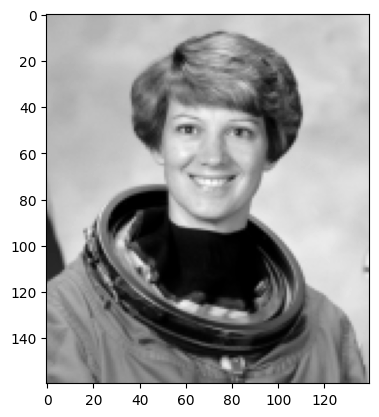

In [ ]:
import skimage
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]


face = face_detection(test_image, svc)
print(f'Number of face detected: {len(face)}')



6 faces are detected


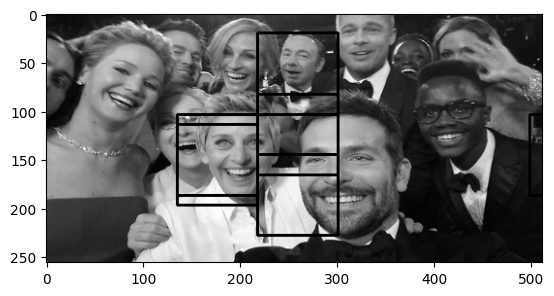

In [ ]:
oscar_selfie= cv2.imread('/content/Selfie Oscar 660x380.jpg', cv2.IMREAD_GRAYSCALE)
oscar_selfie = cv2.resize(oscar_selfie,(512,256))
face = face_detection(oscar_selfie,svc)
print(f'{len(face)} faces are detected')


Number of face detected: 4


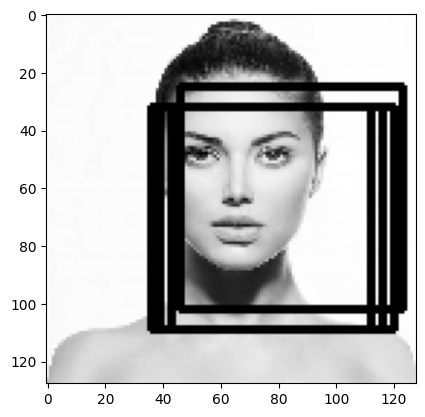

In [ ]:
woman_face= cv2.imread('/content/face.jpg', cv2.IMREAD_GRAYSCALE)
woman_face = cv2.resize(woman_face, (128,128))
face = face_detection(woman_face,svc)
print(f'Number of face detected: {len(face)}')

Number of face detected: 8


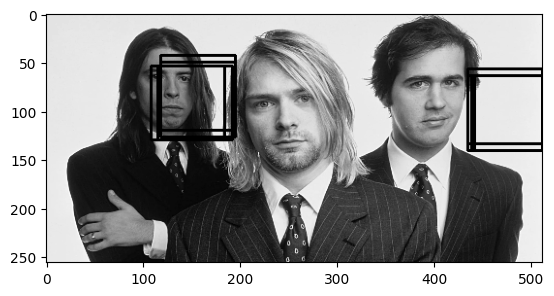

In [ ]:
nirvana= cv2.imread('/content/nirvana2.webp', cv2.IMREAD_GRAYSCALE)
nirvana = cv2.resize(nirvana, (512,256))
face = face_detection(nirvana,svc)
print(f'Number of face detected: {len(face)}')

# Hard mining

In [ ]:
fp = []
for i, test in enumerate(neg_hog):
  test = np.reshape(test,(1,-1))
  if svc.predict(test) == 1:
    fp.append(i)

35

<function matplotlib.pyplot.show(close=None, block=None)>

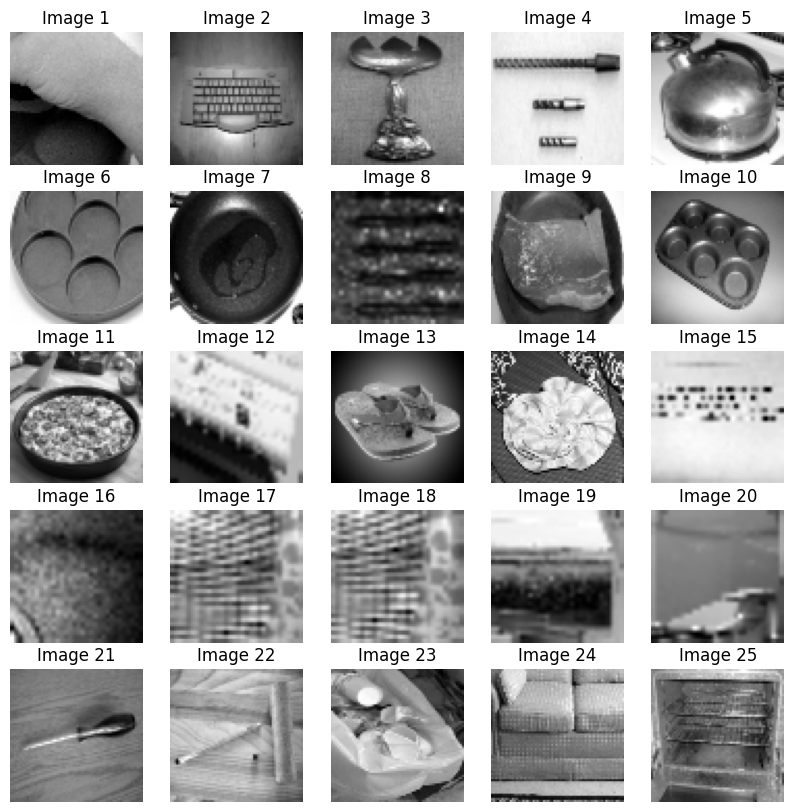

In [ ]:
neg_mining = neg_patches[fp]
len(neg_mining)
plot_images(neg_mining)

# Final comment

The task was more challenging than initially anticipated. Creating a face recognition model using only CSV data without leveraging CNNs resulted in suboptimal performance. As evidenced by the results, face recognition accuracy was inconsistent.

Several potential enhancements could improve model performance:

- Implement image augmentation techniques to increase training data variety
- Fine-tune HOG parameters (orientations, pixels_per_cell, cells_per_block) to optimize feature extraction
- Consider dimensionality reduction techniques to focus on most discriminative features
- Explore ensemble methods combining multiple traditional classifiers
- Implement more robust preprocessing to handle variations in lighting and pose

Despite the limitations, this approach demonstrates that basic face recognition is possible even without deep learning architectures, though with clear trade-offs in accuracy and robustness.